# Time Series Comparison and Prediction of Earth Surface Temperature

The data set we will use is the [Kaggle Berkeley EarthSurface Temperature Study dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). The aim is to predict the analyse this data and predict the future earth surface temperature.

Sources for time series prediction:
1. https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb
2. http://www.ulb.ac.be/di/map/gbonte/ftp/time_ser.pdf
3. https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
4. https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import seaborn
import statistics
import sys, time
import collections
import itertools
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.stats import mode
from scipy.spatial.distance import squareform
from tqdm import tqdm

In [5]:
#Given functions from the tutorial https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for KNN
    max_warping_window : int, optional (default = infinity)
    Maximum warping window allowed by the DTW dynamicprogramming function
    subsample_step : int, optional (default = 1)
    Step size for the timeseries array. By setting subsample_step = 2,
    the timeseries length will be reduced by 50% because every second
    item is skipped. Implemented by x[:, ::subsample_step]
    """
    def __init__(self, n_neighbors=5, max_warping_window=10000,subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Training data set for input into KNN classifer
        l : array of shape [n_samples]
        Training labels for input into KNN classifier
        """
        self.x = x
        self.l = l
    def _dtw_distance(self, ts_a, ts_b, d=lambda x, y: abs(x - y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.
        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared
        d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function
        Returns
        -------
        DTW distance between A and B"""
    #      Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = float('inf') * np.ones((M, N))
        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])
        for j in range(1, N):
            cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])
        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])
            # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        y : array of shape [n_samples, n_timepoints]
        Returns
        -------
        Distance matrix between each item of x and y with
        shape [training_n_samples, testing_n_samples]
        """
        # Compute the distance matrix
        dm_count = 0
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if (np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            p = ProgressBar(shape(dm)[0])
            for i in tqdm(xrange(0, x_s[0] - 1)): #tqdm for progress bar
                for j in xrange(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
                    # Convert to squareform
                    dm = squareform(dm)
            return dm
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]
            p = ProgressBar(dm_size)
            for i in tqdm(range(0, x_s[0])): #tqdm is used to print the progress
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
            return dm

    def predict(self, x):
        """Predict the class labels or probability estimates for
        the provided data
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Array containing the testing data set to be classified
        4
        Returns
        -------
        2 arrays representing:
        (1) the predicted class labels
        (2) the knn label count probability"""
        dm = self._dist_matrix(x, self.x)
        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors
        return mode_label.ravel(), mode_proba.ravel()

#Progressbar is not used because of a bug which prints the progress in next line.
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 50
        self.__update_amount(0)

    def animate(self, iter):
        print('\r', self, end='')
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

## Exploratory Data Analysis
### Analysing and comparing yearly temperatures

The focus is laid upon the countries of Norway, Finland, Singapore and Cambodia.

Norway
Finland
Singapore
Cambodia
[[    0.     7003.473 80893.74  78869.628]
 [ 7003.473     0.    77256.201 75232.089]
 [80893.74  77256.201     0.     1450.473]
 [78869.628 75232.089  1450.473     0.   ]]
As expected the distance between a series and itself is 0. Norway and Finland are most similar with comparable amplitude, amplitude peaks and periods. Consequently    they have a relative low DTW at 7003. Similar to Norway and Finland, Singapore and Combodia have similarities. While they seem more different to each other than the former two    they have a much lower DTW at 1450. Any other combination has a DTW in the range 70000 - 80000 which is reflected in their great difference.


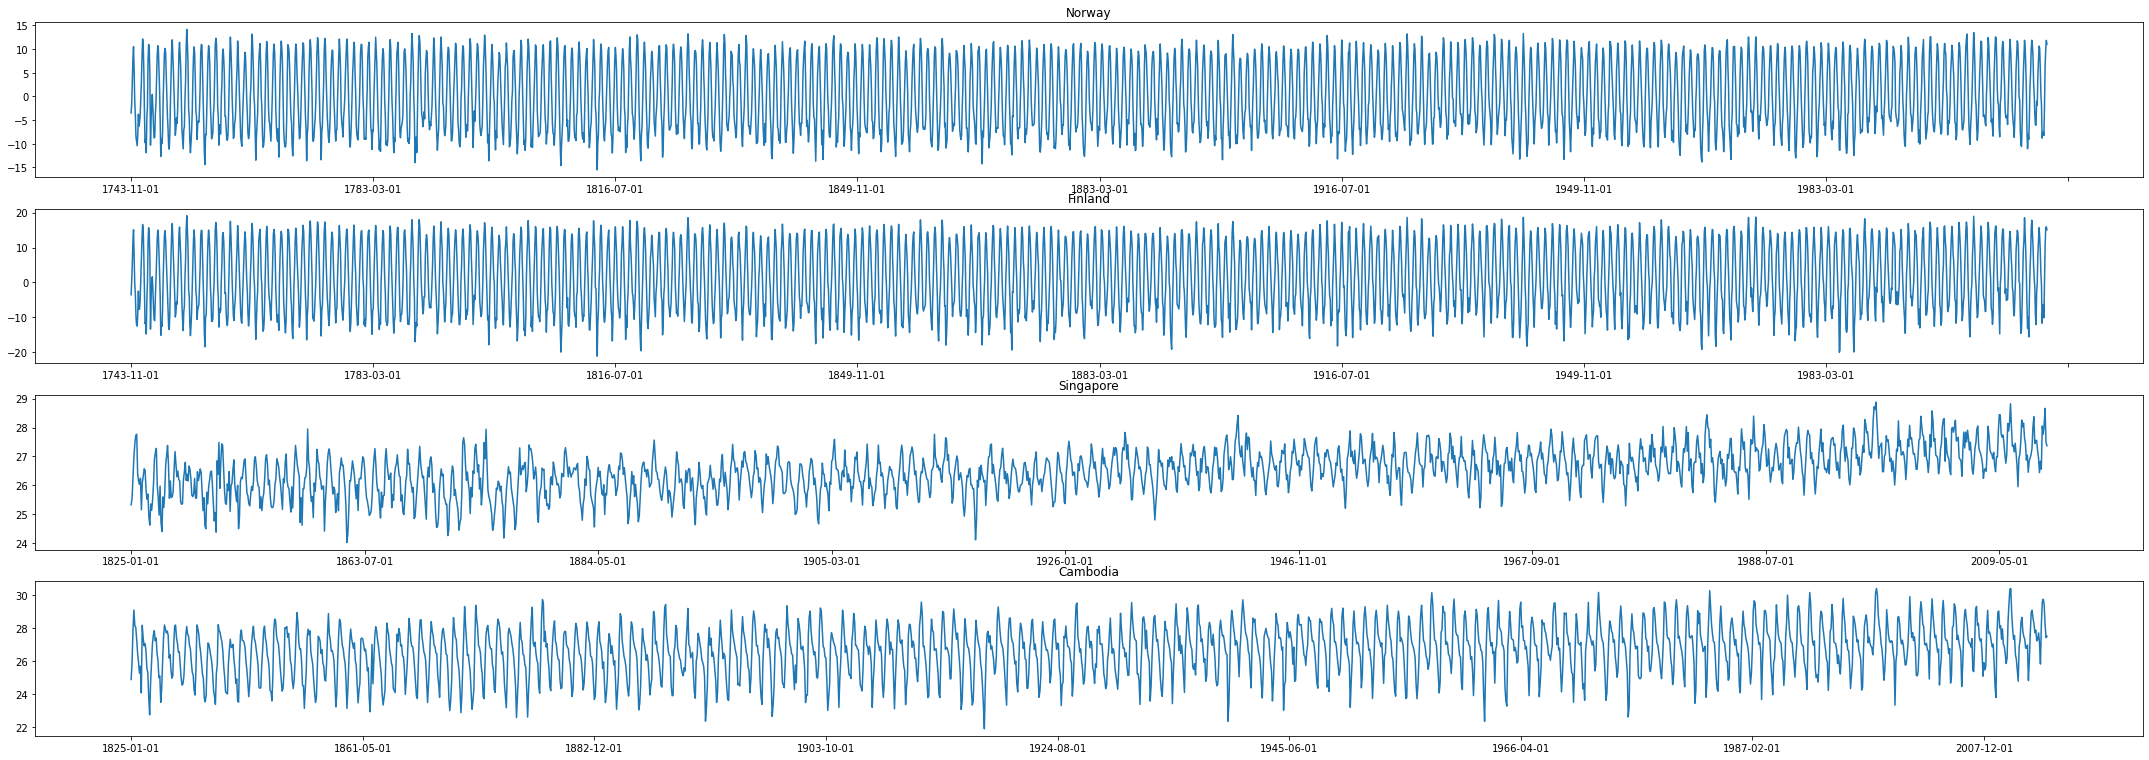

In [7]:
# Read the data for these countrys
data = pd.read_csv('archive/GlobalLandTemperaturesByCountry.csv')
c_list = ['Norway','Finland','Singapore','Cambodia']
c_data = [data[(data['Country'] == country) & (~data['AverageTemperature'].isnull())] for country in c_list]
get_data = lambda country: c_data[c_list.index(country)]

# Plot the DTW distance between each country
fig, axes = plt.subplots(len(c_list))
fig.set_size_inches(30, 10.5)
fig.tight_layout() 

dtw = np.zeros((len(c_list),len(c_list)))
dtw_object = KnnDtw()

for i, (ax, country) in enumerate(zip(axes, c_list)):
    print(country)
    ax.set_title(country)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.plot(get_data(country)['dt'],get_data(country)['AverageTemperature'])
    for i2, country2 in enumerate(c_list):
        dtw[i][i2] = dtw_object._dtw_distance(get_data(country)['AverageTemperature'], get_data(country2)['AverageTemperature'])

print(dtw)
print('As expected the distance between a series and itself is 0. Norway and Finland are most similar with comparable amplitude, amplitude peaks and periods. Consequently\
    they have a relative low DTW at 7003. Similar to Norway and Finland, Singapore and Combodia have similarities. While they seem more different to each other than the former two\
    they have a much lower DTW at 1450. Any other combination has a DTW in the range 70000 - 80000 which is reflected in their great difference.')

### Checking for stationarity
Based on the [tutorial on time series data](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/), we will use the Dickey-Fuller test to evaluate the stationarity of the temperature data for the four countries.

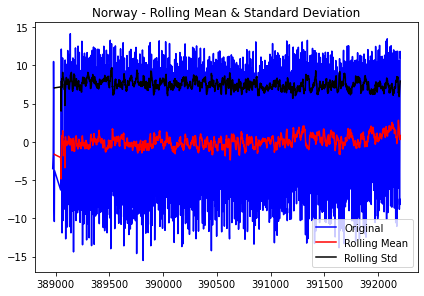

Results of Dickey-Fuller Test:
Test Statistic                -6.718062e+00
p-value                        3.540327e-09
#Lags Used                     2.600000e+01
Number of Observations Used    3.139000e+03
Critical Value (1%)           -3.432435e+00
Critical Value (5%)           -2.862461e+00
Critical Value (10%)          -2.567260e+00
dtype: float64


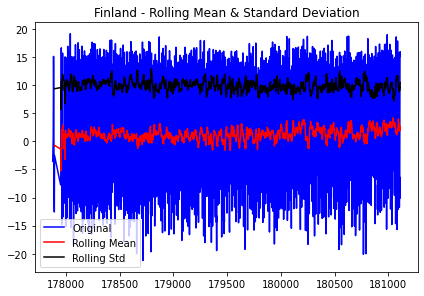

Results of Dickey-Fuller Test:
Test Statistic                -7.701863e+00
p-value                        1.332750e-11
#Lags Used                     2.400000e+01
Number of Observations Used    3.141000e+03
Critical Value (1%)           -3.432434e+00
Critical Value (5%)           -2.862461e+00
Critical Value (10%)          -2.567260e+00
dtype: float64


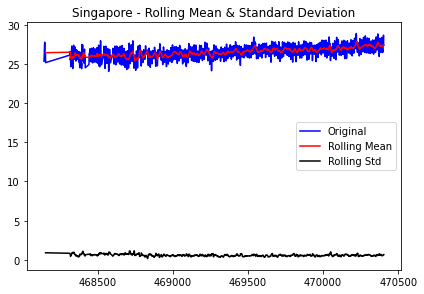

Results of Dickey-Fuller Test:
Test Statistic                   -2.995178
p-value                           0.035347
#Lags Used                       25.000000
Number of Observations Used    2026.000000
Critical Value (1%)              -3.433582
Critical Value (5%)              -2.862968
Critical Value (10%)             -2.567530
dtype: float64


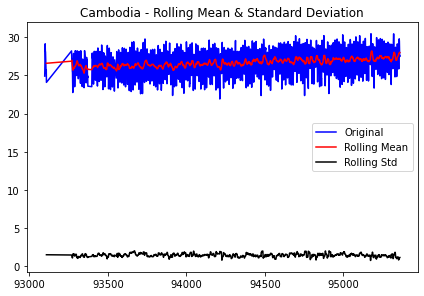

Results of Dickey-Fuller Test:
Test Statistic                   -3.855150
p-value                           0.002391
#Lags Used                       25.000000
Number of Observations Used    2043.000000
Critical Value (1%)              -3.433555
Critical Value (5%)              -2.862956
Critical Value (10%)             -2.567524
dtype: float64


In [8]:
# Taken from the tutorial at https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, country):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.title(country + ' - Rolling Mean & Standard Deviation')
    plt.show(block=False)


    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


for country in c_list:
    test_stationarity(get_data(country)['AverageTemperature'], country)

## Preprocessing
### De-Trend Data
Because temperature and weather data includes seasons, day and night temperature changes as well as global warming, we need to de trend and remove the effects of seasonality to obtain stationary. Differencing and decomposition techniques  from [tutorial on time series data](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) are used.

Norway
Finland
Singapore
Cambodia
[[    0.          4187.98686033  8703.64848542  7290.01669463]
 [ 4187.98686033     0.         12141.63243602 10566.50861158]
 [ 8703.64848542 12141.63243602     0.          1094.11918343]
 [ 7290.01669463 10566.50861158  1094.11918343     0.        ]]


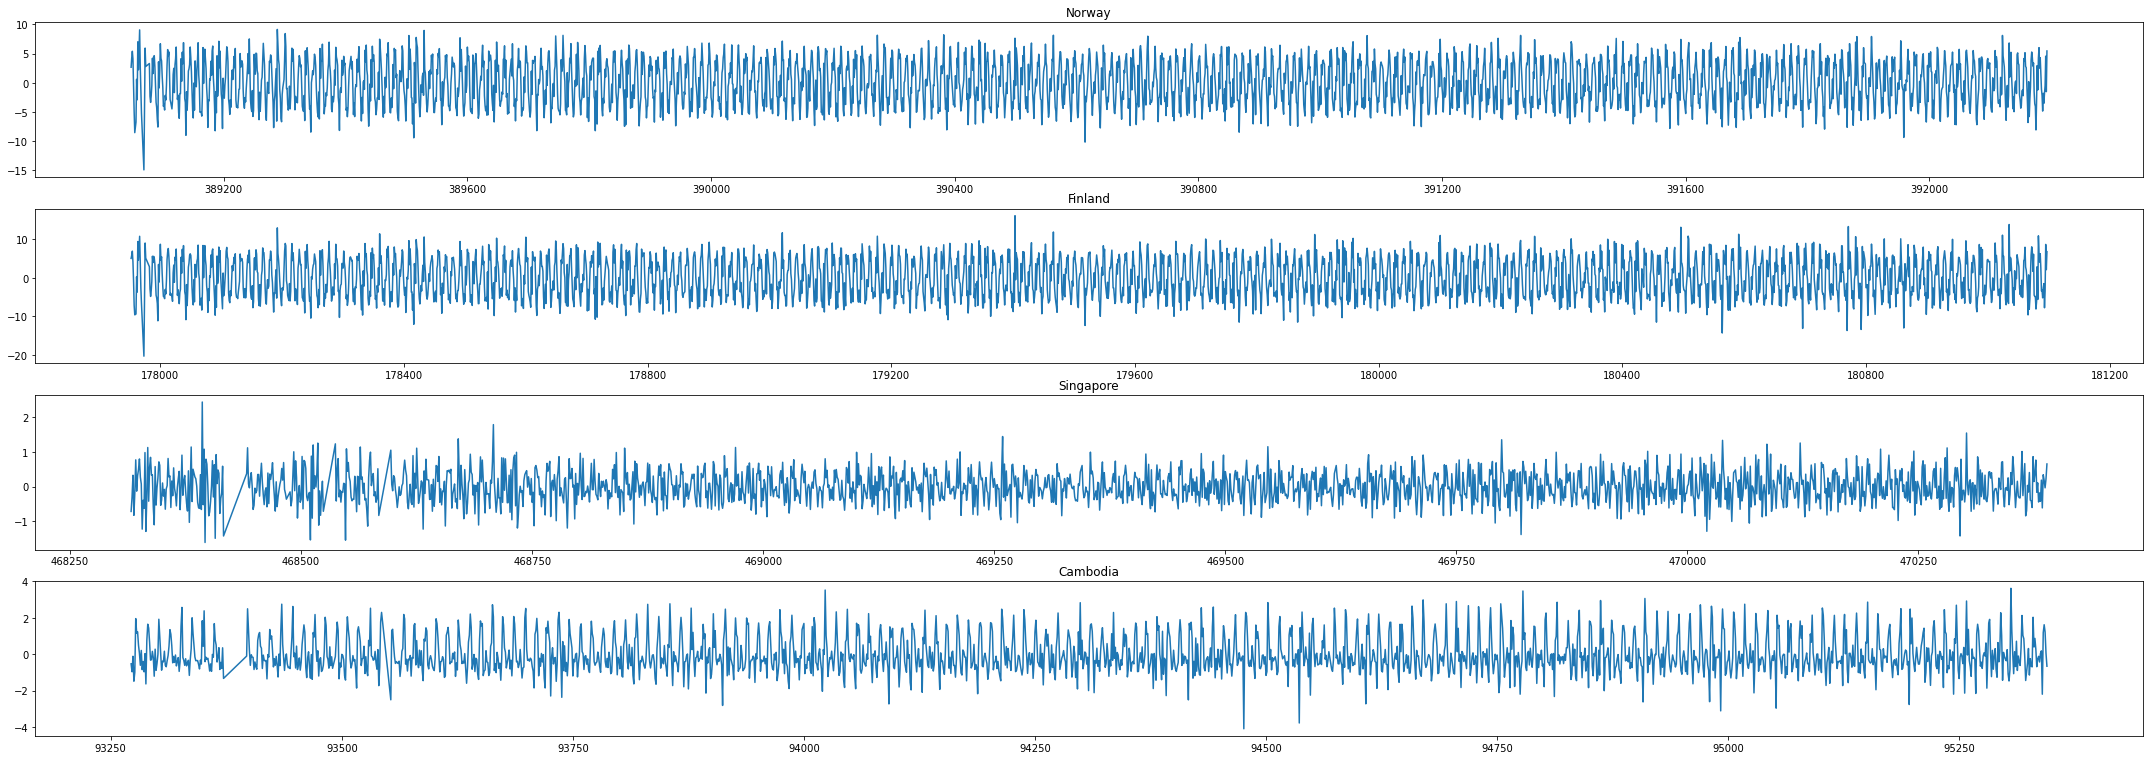

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

def differencing(ts):
    ts_diff = ts - ts.shift(periods= 1, axis=0)
    ts_diff.dropna(inplace = True)
    #ts_diff = ts.diff(periods=1)

    return ts_diff

def decompose(ts):
    decomposition = seasonal_decompose(ts, period = 31)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    residual.dropna(inplace=True)

    return residual

def remove_season_trend(timeseries):
    return decompose(differencing(timeseries))

# for country in c_list:
#     test_stationarity(remove_season_trend(get_data(country)['AverageTemperature']), country)


# Apply DTW to compare decomposed and differenced versions
fig, axes = plt.subplots(len(c_list))
fig.set_size_inches(30, 10.5)
fig.tight_layout()

dtw = np.zeros((len(c_list),len(c_list)))
dtw_object = KnnDtw()

for i, (ax, country) in enumerate(zip(axes, c_list)):
    print(country)
    ax.set_title(country)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.plot(remove_season_trend(get_data(country)['AverageTemperature']))
    for i2, country2 in enumerate(c_list):
        dtw[i][i2] = dtw_object._dtw_distance(remove_season_trend(get_data(country)['AverageTemperature']), remove_season_trend(get_data(country2)['AverageTemperature']))

print(dtw)

## Preciction ARIMA
 We will apply the AR, AM and ARIMA model on the temperature data. The ACF and PACF plots are used to determine the values for p, q and d in the model.

C:\Users\Noor1\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Noor1\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


As the plots show, the p value should be 1 and for q 1. Since we differenced the time series only one time d = 0


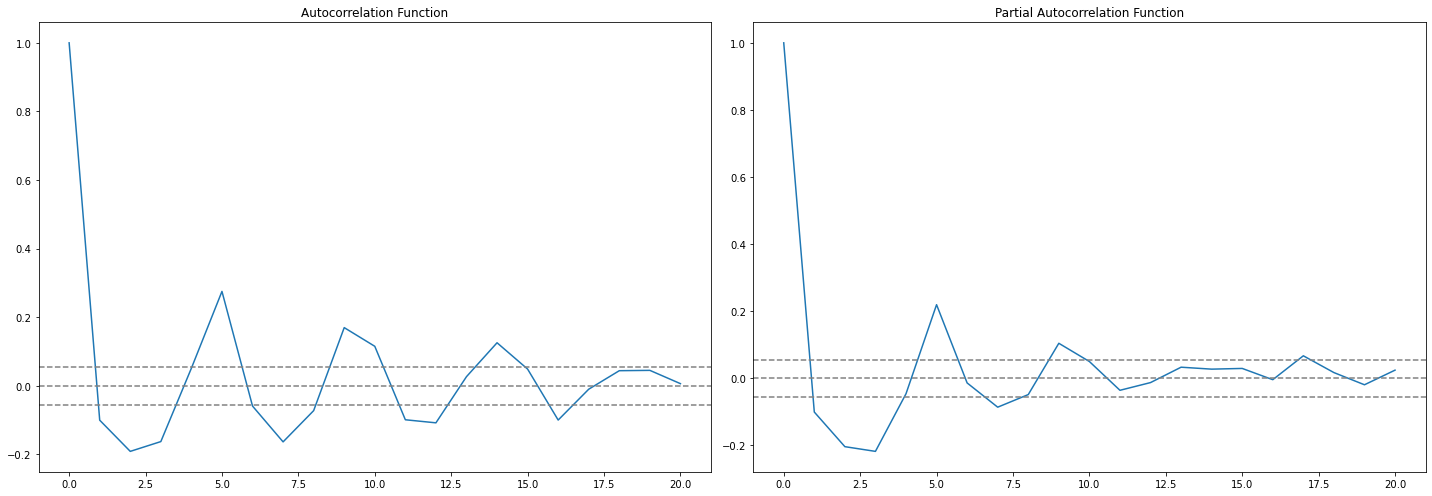

In [10]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# Adapt Indexing and difference timeseries
ts = get_data(c_list[0])

# Apply differencing
ts_log = np.log(ts['AverageTemperature'])
ts_log_diff = differencing(ts_log)


lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

print(f'As the plots show, the p value should be 1 and for q 1. Since we differenced the time series only one time d = 0')

C:\Users\Noor1\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


One can see from the results that the MA method is slightly better than the Ar method, but the combined method outperforms them significantly


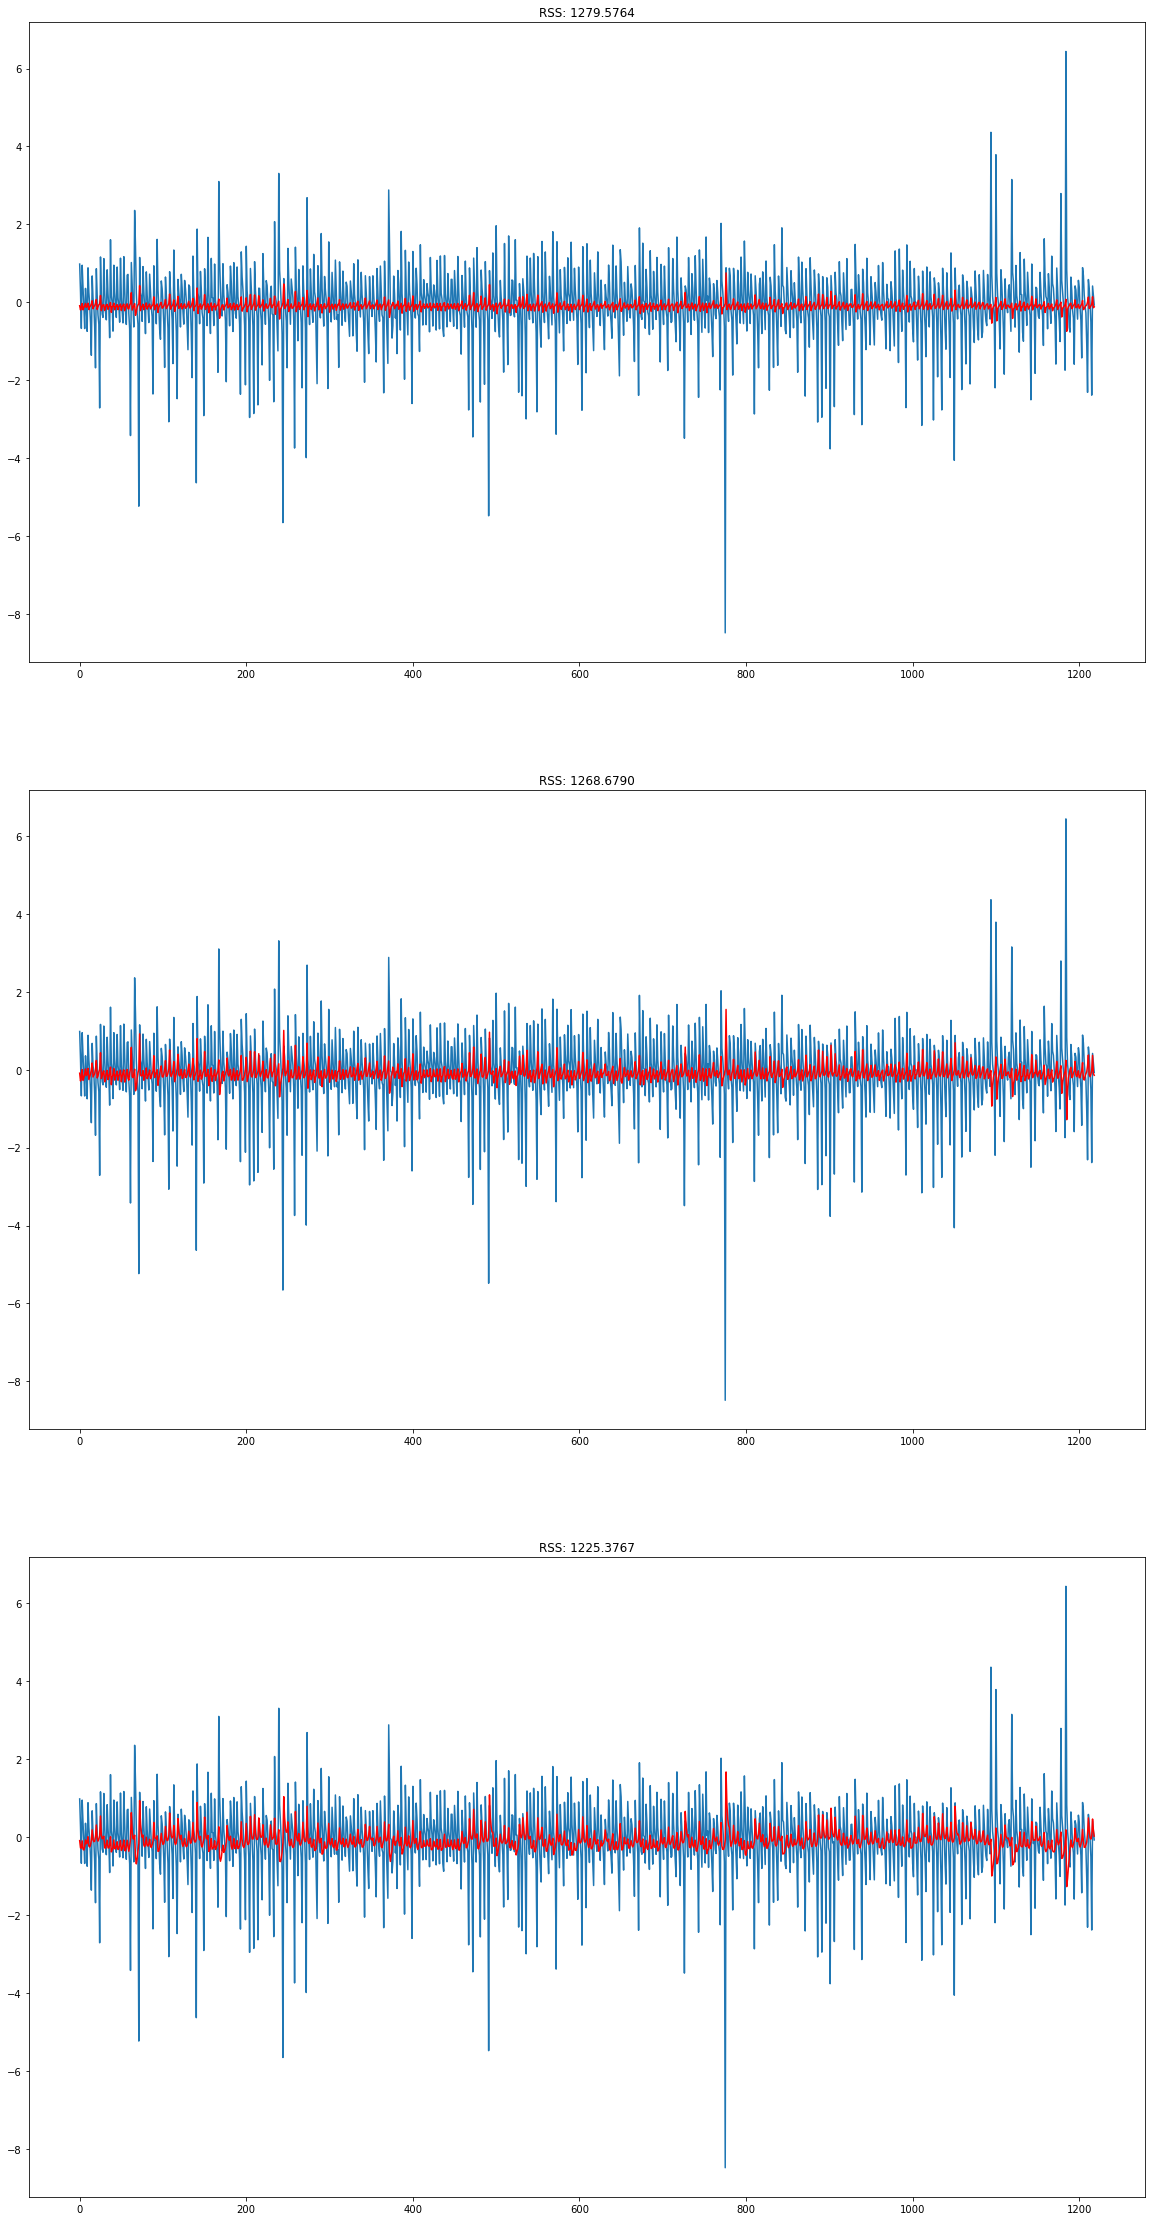

In [11]:
from statsmodels.tsa.arima_model import ARIMA

new_index = [i for i in range(0,len(ts_log_diff))]
ts_log_diff.index = new_index

#Apply AR MODEL - order (p,d,q) = (1,0,1)
model_AR = ARIMA(ts_log_diff, order=(1, 0, 0))
results_AR = model_AR.fit(disp=-1)
fig, ax = plt.subplots(3,1, figsize = (20,40))
ax[0].plot(ts_log_diff)
ax[0].plot(results_AR.fittedvalues, color='red')
ax[0].set_title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

#Apply MA MODEL
model_MA = ARIMA(ts_log_diff, order=(0, 0, 1))
results_MA = model_MA.fit(disp=-1)
ax[1].plot(ts_log_diff)
ax[1].plot(results_MA.fittedvalues, color='red')
ax[1].set_title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

#Apply ARIMA - combined model
model_ARIMA = ARIMA(ts_log_diff, order=(1, 0, 1))
results_ARIMA = model_ARIMA.fit(disp=-1)
ax[2].plot(ts_log_diff)
ax[2].plot(results_ARIMA.fittedvalues, color='red')
ax[2].set_title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
print(f'One can see from the results that the MA method is slightly better than the Ar method, but the combined method outperforms them significantly')

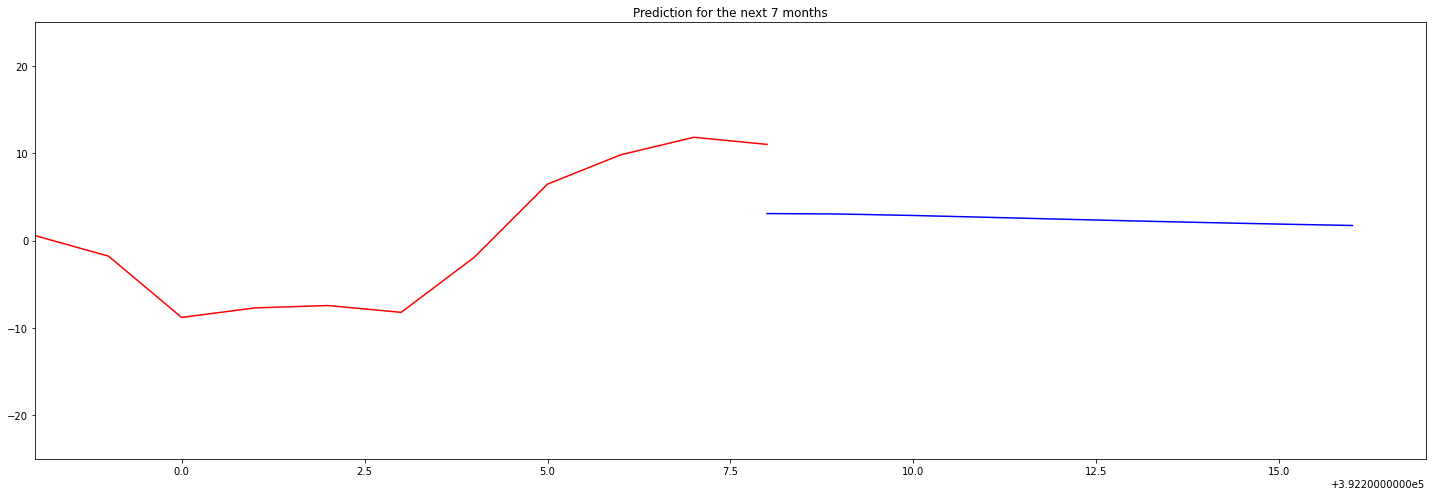

In [12]:
# Predict next 7 months values with ARIMA MODEL
start = len(ts_log_diff)
end = start + 7
predicted_values = results_ARIMA.predict(start= start-1, end= end)
predicted_values.index = range(ts.index[-1],ts.index[-1] + 9)

# Get and add the cumsum to reverse differencing
ARIMA_diff_cumsum = predicted_values.cumsum()
# print(ARIMA_diff_cumsum.head())
ARIMA_log_shift = pd.Series(ts_log.iloc[2], index=predicted_values.index)
# print(ARIMA_log_shift)
ARIMA_log = ARIMA_log_shift.add(ARIMA_diff_cumsum,fill_value=0)
# print(f'Log unshifted{ARIMA_log.head()}')


# Plot the results
fig, ax = plt.subplots(1, figsize = (20,7))
og_data = get_data(c_list[0])['AverageTemperature']
ax.plot(og_data, color = 'red', label = 'Old')
ax.plot(np.exp(ARIMA_log), color = 'blue', label = 'Prediction')
ax.set_ylim([-25,25])
ax.set_xlim([ts.index[-1]-10,ts.index[-1] + 9])
ax.set_title(f'Prediction for the next 7 months')
fig.tight_layout()